In [1]:
import gym
import sys 
sys.path.append("C:/Users/levyb/Documents/Masters Data Science - 2nd Year/deepHedgingRL")
import numpy as np
import torch
import matplotlib.pyplot as plt
import tensorflow as tf
from src.pricing.asset_price_process import GBM
from src.pricing.option_price_process import BSM
from src.custom_environments.HedgeEnv_PPO import env_hedging_ppo
from torch import nn
import time



In [2]:
mu = 0
dt = 1/5
T = 10
num_steps = int(T/dt)
s_0 = float(100)
strike_price = s_0
sigma = 0.01*dt
r = 0

def cost(delta_h, multiplier):
    TickSize = 0.1
    return multiplier * TickSize * (np.abs(delta_h) + 0.01 * delta_h**2)


apm = GBM(mu=mu, dt=dt, s_0=s_0, sigma=sigma)
opm = BSM(strike_price=strike_price, risk_free_interest_rate=r, volatility=sigma, T=T, dt=dt)
env = env_hedging_ppo(asset_price_model=apm, dt=dt, T=T, num_steps=num_steps, cost_multiplier = 1, tick_size=0.01,
                     L=1, strike_price=strike_price, int_holdings=True, initial_holding=0, mode="PL",
                  option_price_model=opm)




In [3]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.utils import get_schedule_fn
import torch.nn as nn
import torch
import gym
import os 

# Custom Feature Extractor with 5 hidden layers and batch normalization
class CustomFeatureExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 201):
        super(CustomFeatureExtractor, self).__init__(observation_space, features_dim)
        
        input_dim = observation_space.shape[0]  # Assuming the input is a 1D vector

        self.fc_net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            
            nn.Linear(128, 256),
            nn.BatchNorm1d(256), 
            nn.ReLU(),
            
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),  
            nn.ReLU(),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),  
            nn.ReLU(),
            
            nn.Linear(128, features_dim),
            nn.BatchNorm1d(features_dim), 
            nn.ReLU()
        )

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        return self.fc_net(observations)
    
# Learning rate schedule as per the paper
lr_schedule = get_schedule_fn(1e-4)

# Custom callback to log rewards during training
from stable_baselines3.common.callbacks import BaseCallback

class RewardCallback(BaseCallback):
    def __init__(self, check_freq: int, verbose=1):
        super(RewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.rewards = []

    def _on_step(self) -> bool:
        reward = self.locals["rewards"][0]  # Access the current reward
        if self.n_calls % self.check_freq == 0:
            self.rewards.append(reward)  # Log rewards at each check frequency
        return True

# Set up callback and directories for logging and saving models
callback = RewardCallback(check_freq=1000, verbose=1)

models_dir = "models/PPO"
logdir = "logs"

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

if not os.path.exists(logdir):
    os.makedirs(logdir)

# Instantiate and train the PPO model as per the Du paper
model = PPO(policy="MlpPolicy", 
    env=env,  
    learning_rate=lr_schedule,
    verbose=1,
    gae_lambda=0.96, 
    gamma=0.85, 
    batch_size=32, 
    n_steps=2048,  
    policy_kwargs=dict(features_extractor_class=CustomFeatureExtractor),
    ent_coef=0.01,  # Entropy coefficient for exploration
    vf_coef=0.5,  # Value function coefficient
    max_grad_norm=1.0,  # Gradient clipping
    tensorboard_log=logdir
)

# Train the model in increments and save after each block of timesteps
TIMESTEPS = 100000
for i in range(1, 16):
    model.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=False, tb_log_name="PPO", callback=callback)
    model.save(f"{models_dir}/ppo_{TIMESTEPS * i}")



Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\levyb\Documents\Masters Data Science - 2nd Year\deepHedgingRL\hedge_env\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Logging to logs\PPO_0


C:\Users/levyb/Documents/Masters Data Science - 2nd Year/deepHedgingRL\src\pricing\option_price_process.py:66: RuntimeWarning: divide by zero encountered in scalar divide
  d_1 = (np.log(asset_price / self.strike_price) + (self.risk_free_interest_rate + self.volatility**2 / 2)


----------------------------------
| rollout/           |           |
|    ep_len_mean     | 50        |
|    ep_rew_mean     | -2.24e+03 |
| time/              |           |
|    fps             | 514       |
|    iterations      | 1         |
|    time_elapsed    | 3         |
|    total_timesteps | 2048      |
----------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 50          |
|    ep_rew_mean          | -1.73e+03   |
| time/                   |             |
|    fps                  | 241         |
|    iterations           | 2           |
|    time_elapsed         | 16          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.010552083 |
|    clip_fraction        | 0.0838      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.42       |
|    explained_variance   | 0.000153    |
|    learning_rate  

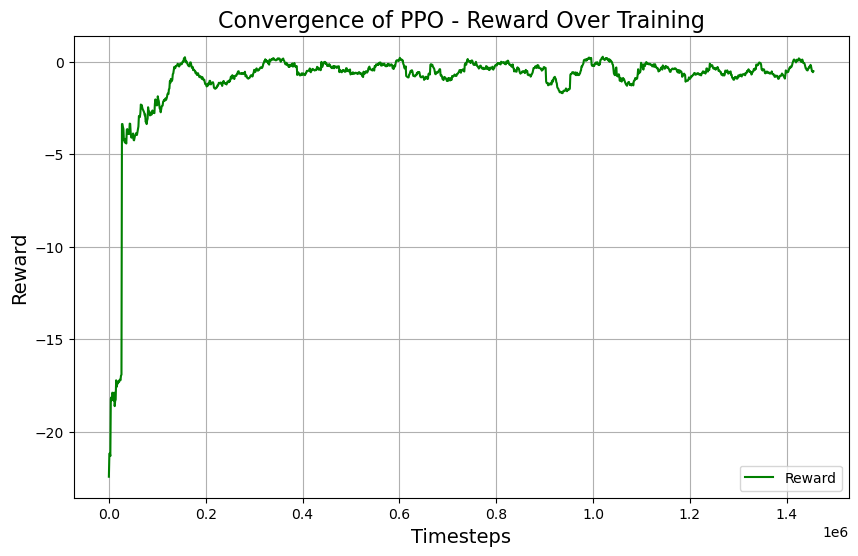

In [61]:
# from scipy.ndimage import gaussian_filter1d

# # Calculate moving average to smooth the curve
# window_size = 50 # Adjust the window size as needed
# smoothed_rewards = np.convolve(callback.rewards, np.ones(window_size)/window_size, mode='valid')

# # Alternatively, you can use Gaussian smoothing for more flexible control:
# # smoothed_rewards = gaussian_filter1d(callback.rewards, sigma=2)

# # Adjust train_data_point to match the length of smoothed_rewards
# train_data_point = np.arange(len(smoothed_rewards)) * callback.check_freq

# plt.figure(figsize=(10, 6))
# plt.plot(train_data_point, smoothed_rewards, label='Reward', color='green')
# plt.xlabel('Timesteps', fontsize=14)
# plt.ylabel('Reward', fontsize=14)
# plt.title('Convergence of PPO - Reward Over Training', fontsize=16)
# plt.legend(loc='best')
# plt.grid(True)
# plt.savefig("PPO_Convergence_1500000.png")
# plt.show()

C:\Users/levyb/Documents/Masters Data Science - 2nd Year/deepHedgingRL\src\pricing\option_price_process.py:66: RuntimeWarning: divide by zero encountered in scalar divide
  d_1 = (np.log(asset_price / self.strike_price) + (self.risk_free_interest_rate + self.volatility**2 / 2)


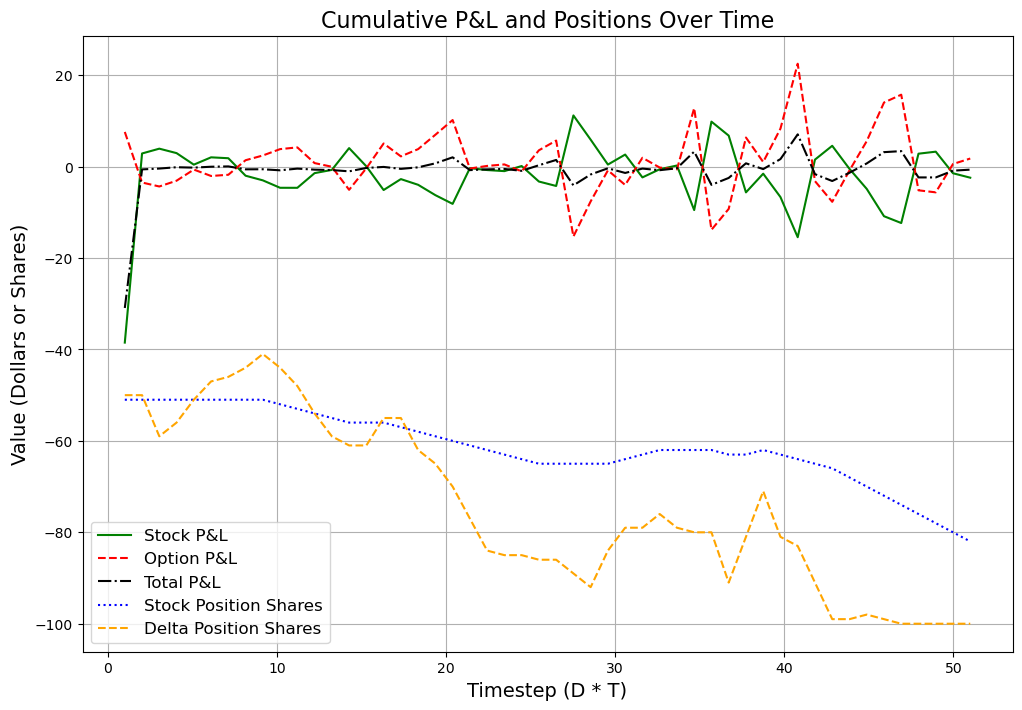

In [5]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.utils import get_schedule_fn
import os 

model = PPO.load("C:/Users/levyb/Documents/Masters Data Science - 2nd Year/deepHedgingRL/notebooks/models/PPO/ppo_1400000.zip")
num_episodes = 1

for episode in range(num_episodes): 
    state = env.reset()
    done = False
    cum_option_pnl = 0
    cum_stock_pnl = 0
    cum_cost_pnl = 0
    option_pnls = []
    stock_pnls = []
    cost_pnls = []
    total_pnl = []
    stock_pos_shares =[]
    delta_pos_shares = []
    
    while not done:
        current_state = env.get_state()
        delta_action = -100 * round(current_state[4], 2)
        action, _states = model.predict(current_state, deterministic = True)
        next_state, reward, done, info = env.step(action)
        delta_h =   next_state[0]-current_state[0]
        option_pnl = (100*(next_state[3]-current_state[3]))
        stock_pnl = (-current_state[0]*(next_state[1] -current_state[1])-cost(delta_h, 5))
        cum_option_pnl =+ option_pnl
        cum_stock_pnl =+ stock_pnl
        cum_cost_pnl =+ cost(delta_h, 5)

        option_pnls.append(cum_option_pnl)
        stock_pnls.append(cum_stock_pnl)
        cost_pnls.append(cum_cost_pnl)
        total_pnl.append(cum_option_pnl+cum_stock_pnl)
        stock_pos_shares.append(-next_state[0])
        delta_pos_shares.append(delta_action)

        if done:
            state = env.reset()

    time_axis = np.linspace(1, num_steps+1, num_steps)
    plt.figure(figsize=(12, 8))
    plt.plot(time_axis, stock_pnls, label='Stock P&L', color='green', linestyle='-')
    plt.plot(time_axis, option_pnls, label='Option P&L', color='red', linestyle='--')
    #plt.plot(time_axis, cost_pnls, label='Cost P&L', color='magenta', linestyle='--')
    plt.plot(time_axis, total_pnl, label='Total P&L', color='black', linestyle='-.')
    plt.plot(time_axis, stock_pos_shares, label='Stock Position Shares', color='blue', linestyle=':')
    plt.plot(time_axis, delta_pos_shares, label='Delta Position Shares', color='orange', linestyle='--')

    # Add labels, title, and legend
    plt.xlabel('Timestep (D * T)', fontsize=14)
    plt.ylabel('Value (Dollars or Shares)', fontsize=14)
    plt.title('Cumulative P&L and Positions Over Time', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)
    #plt.savefig("models/PPO/Cost5")

    plt.show()

In [ ]:
from scipy.ndimage import gaussian_filter1d

# Calculate moving average to smooth the curve
window_size = 50 # Adjust the window size as needed
smoothed_rewards = np.convolve(callback.rewards, np.ones(window_size)/window_size, mode='valid')

# Alternatively, you can use Gaussian smoothing for more flexible control:
# smoothed_rewards = gaussian_filter1d(callback.rewards, sigma=2)

# Adjust train_data_point to match the length of smoothed_rewards
train_data_point = np.arange(len(smoothed_rewards)) * callback.check_freq

plt.figure(figsize=(10, 6))
plt.plot(train_data_point, smoothed_rewards, label='Reward', color='green')
plt.xlabel('Timesteps', fontsize=14)
plt.ylabel('Reward', fontsize=14)
plt.title('Convergence of PPO - Reward Over Training', fontsize=16)
plt.legend(loc='best')
plt.grid(True)
plt.savefig("PPO_Convergence_1500000.png")
plt.show()


C:\Users/levyb/Documents/Masters Data Science - 2nd Year/deepHedgingRL\src\pricing\option_price_process.py:66: RuntimeWarning: divide by zero encountered in scalar divide
  d_1 = (np.log(asset_price / self.strike_price) + (self.risk_free_interest_rate + self.volatility**2 / 2)
C:\Users\levyb\AppData\Local\Temp\ipykernel_18276\997716716.py:97: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(cost_pnls_ppo, label='Policy: ppo', shade=True)
C:\Users\levyb\AppData\Local\Temp\ipykernel_18276\997716716.py:98: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(cost_pnls_dh, label='Policy: $\delta_{DH}$', shade=True)
C:\Users\levyb\AppData\Local\Temp\ipykernel_18276\997716716.py:106: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fil

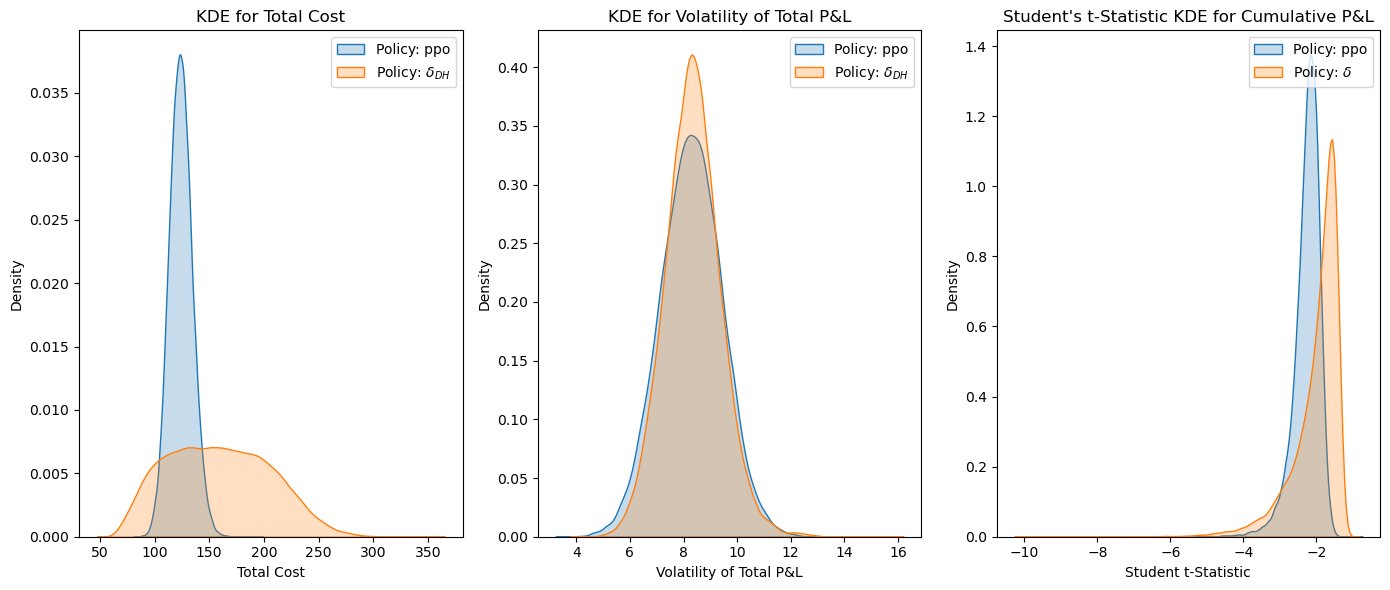

In [344]:
def student_t_statistic(data):
    n = len(data)
    sample_mean = np.mean(data)
    sample_std = np.std(data, ddof=1)
    t_statistic = sample_mean / (sample_std / np.sqrt(n))
    return t_statistic

# Getting kernel density estimates for cost and volatility
num_episodes = 38500
cost_pnls_dh = []
cost_pnls_ppo = []
total_pnls_vol_dh = []
total_pnls_vol_ppo = []
t_stat_pnls_dh = []
t_stat_pnls_ppo = []

for episode in range(num_episodes): 
    state = env.reset()
    done = False
    deltas = [0]
    samp_cost_pnl_dh = 0
    samp_cost_pnl_ppo = 0

    pnl_diffs_ppo = []
    pnl_diffs_dh = []
    
    previous_pnl_ppo = 0
    previous_pnl_dh = 0
    
    total_pnl_ppo = 0
    total_pnl_dh = 0
    samp_total_pnl_dh = []
    samp_total_pnl_ppo = []

    while not done:
        current_holdings, current_asset_price, current_ttm, current_option_price, current_delta = env.get_state()
        delta_holding = -100 * round(current_delta, 2)
        delta_h_dh = delta_holding - deltas[-1]
        deltas.append(delta_holding)

        action, _states = model.predict(env.get_state(), deterministic=False)
        next_state, reward, done, info = env.step(action-0)
        next_holdings, next_asset_price, next_ttm, next_option_price, next_delta = next_state
        delta_h_ppo = next_holdings-current_holdings

        # Cost calculations for both policies
        samp_cost_pnl_dh += cost(delta_h_dh, 5)
        samp_cost_pnl_ppo += cost(delta_h_ppo, 5)

        # P&L differences between steps
        pnl_ppo = (100 * (next_option_price - current_option_price) - current_holdings * (next_asset_price - current_asset_price) - cost(delta_h_ppo, 5))
        pnl_dh = (100 * (next_option_price - current_option_price) + deltas[-2] * (next_asset_price - current_asset_price) - cost(delta_h_dh, 5))
        
        pnl_diffs_ppo.append(pnl_ppo - previous_pnl_ppo)
        pnl_diffs_dh.append(pnl_dh - previous_pnl_dh)

        # Update previous P&L
        previous_pnl_ppo = pnl_ppo
        previous_pnl_dh = pnl_dh

        # Accumulate the cumulative P&L for each policy
        total_pnl_ppo+= pnl_ppo
        total_pnl_dh += pnl_dh
        samp_total_pnl_ppo.append(total_pnl_ppo)
        samp_total_pnl_dh.append(total_pnl_dh)



        if done:
            # Volatility is the standard deviation of P&L differences
            vol_ppo = np.std(pnl_diffs_ppo)
            vol_dh = np.std(pnl_diffs_dh)

            # Calculate student t-statistic based on cumulative P&L at the end of the episode
            t_stat_pnl_ppo = student_t_statistic(samp_total_pnl_ppo)  # Use cumulative P&L
            t_stat_pnl_dh = student_t_statistic(samp_total_pnl_dh)  # Use cumulative P&L

            # Append cost and volatility for this episode
            cost_pnls_ppo.append(samp_cost_pnl_ppo)
            cost_pnls_dh.append(samp_cost_pnl_dh)
            total_pnls_vol_ppo.append(vol_ppo)
            total_pnls_vol_dh.append(vol_dh)
            t_stat_pnls_ppo.append(t_stat_pnl_ppo)
            t_stat_pnls_dh.append(t_stat_pnl_dh)

            state = env.reset()

# Plotting the KDE and results
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# Plot kernel density estimates for total cost
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
sns.kdeplot(cost_pnls_ppo, label='Policy: ppo', shade=True)
sns.kdeplot(cost_pnls_dh, label='Policy: $\delta_{DH}$', shade=True)
plt.title('KDE for Total Cost')
plt.xlabel('Total Cost')
plt.ylabel('Density')
plt.legend()

# Plot kernel density estimates for volatility of total P&L
plt.subplot(1, 3, 2)
sns.kdeplot(total_pnls_vol_ppo, label='Policy: ppo', shade=True)
sns.kdeplot(total_pnls_vol_dh, label='Policy: $\delta_{DH}$', shade=True)
plt.title('KDE for Volatility of Total P&L')
plt.xlabel('Volatility of Total P&L')
plt.ylabel('Density')
plt.legend()

# Plot KDE for Student's t-statistic of Cumulative P&L
plt.subplot(1, 3, 3)
sns.kdeplot([x/10 for x in t_stat_pnls_ppo], label='Policy: ppo', shade=True)
sns.kdeplot([x/10 for x in t_stat_pnls_dh], label='Policy: $\delta_{DH}$', shade=True)
plt.title("Student's t-Statistic KDE for Cumulative P&L")
plt.xlabel('Student t-Statistic')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()


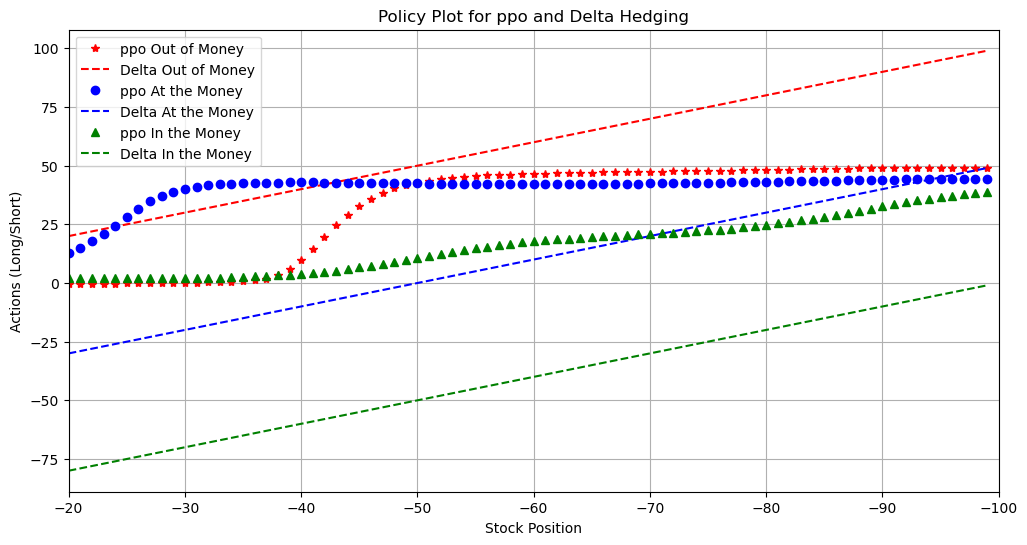

In [11]:
# Define parameters for the BSM model
strike_price = 100
env.reset()
# Define stock prices for out-of-the-money, at-the-money, and in-the-money scenarios
stock_prices = [98, 100, 102] 
time_to_maturity = 1/5

# Initialize arrays to store actions
ppo_actions_out_of_money = []
ppo_actions_at_money = []
ppo_actions_in_money = []


stock_positions = np.arange(-20, -100, -1)  # Adjust as necessary
deltas_out= np.arange(0.20,1, 0.01)
deltas_at = np.arange(-0.30, 0.50, 0.01)
deltas_in = np.arange(-0.80,0, 0.01)



for i in range(len(stock_positions)):
    # Time to maturity remains constant for this plot
    ttm = time_to_maturity  # Time to maturity in years

    # Out-of-the-money (S = 98)
    S_out = 98
    # Compute option price and delta
    option_price_out = opm.compute_option_price(ttm, S_out, mode='ttm')
    env.set_state(stock_positions[i], S_out, ttm, option_price_out, deltas_out[i])
    action_out, _ = model.predict(env.get_state(), deterministic=True)
    ppo_actions_out_of_money.append(100*action_out)

    # At-the-money (S = 100)
    S_at = 100
    option_price_at = opm.compute_option_price(ttm, S_at, mode='ttm')
    env.set_state(stock_positions[i], S_at, ttm, option_price_out,deltas_at[i])
    action_at, _ = model.predict(env.get_state(), deterministic=True)
    ppo_actions_at_money.append(100*action_at)


    # In-the-money (S = 102)
    S_in = 102
    option_price_in = opm.compute_option_price(ttm, S_in, mode='ttm')
    env.set_state(stock_positions[i], S_in, ttm, option_price_out, deltas_in[i])
    action_in, _ = model.predict(env.get_state(), deterministic=True)
    ppo_actions_in_money.append(100*action_in)

# Plotting
plt.figure(figsize=(12, 6))

# Out-of-the-money
plt.plot(stock_positions, ppo_actions_out_of_money, label="ppo Out of Money", marker="*", linestyle="", color= "red")
plt.plot(stock_positions, [x*100 for x in deltas_out], label="Delta Out of Money", linestyle="--",color= "red")

# At-the-money
plt.plot(stock_positions, ppo_actions_at_money, label="ppo At the Money", marker="o", linestyle="", color = "blue")
plt.plot(stock_positions, [x*100 for x in deltas_at], label="Delta At the Money", linestyle="--", color = "blue")

# In-the-money
plt.plot(stock_positions, ppo_actions_in_money, label="ppo In the Money", marker="^", linestyle="", color ="green")
plt.plot(stock_positions, [x*100 for x in deltas_in], label="Delta In the Money", linestyle="--", color = "green")

plt.xlim(-20, -100)
plt.title("Policy Plot for ppo and Delta Hedging")
plt.xlabel("Stock Position")
plt.ylabel("Actions (Long/Short)")
plt.legend()
plt.grid(True)
plt.savefig("PPO Policy Plot")
plt.show()
